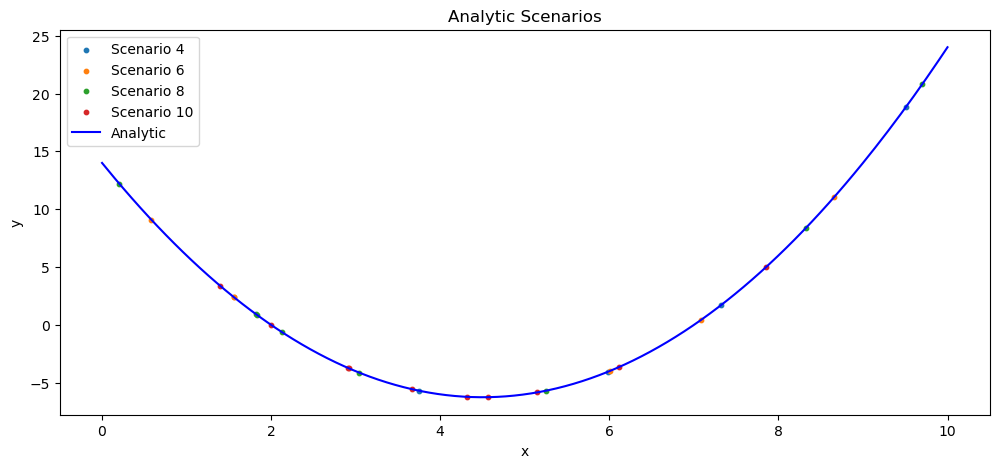

In [36]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)

f_true = lambda x: x**2 - 9*x + 14

# Scenarios
scenarios = [4, 6, 8, 10]

seed = 42
np.random.seed(seed)

# Dictionary to store data
scenario_data = {}

# Plotting setup
plt.figure(figsize=(12, 5))

# Process each scenario
for n in scenarios:
    # Draw from a uniform distribution randomly
    X_train = np.random.uniform(0, 10, n)
    Y_train = np.array([f_true(xt) for xt in X_train])

    # Store data in the dictionary
    scenario_data[n] = (X_train, Y_train)
    plt.scatter(X_train, Y_train, label=f"Scenario {n}", s=10)

# Analytic data with 200 points
X_analytic = np.linspace(0, 10, 200)
Y_analytic = f_true(X_analytic)

plt.title("Analytic Scenarios")
plt.plot(X_analytic, Y_analytic, label="Analytic", color="blue")
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


In [37]:
import GPy

# Dictionary to store GP models
gp_models = {}

for n in scenarios:
    # Retrieve training data for this scenario
    X_train, Y_train = scenario_data[n]

    # Define the kernel
    kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

    # Create the GP model
    gp_model = GPy.models.GPRegression(X_train.reshape(-1,1), Y_train.reshape(-1,1), kernel)

    # Optimize the model (find the best hyperparameters)
    gp_model.optimize(messages=True)

    # Store the optimized model
    gp_models[n] = gp_model

    # Print the optimized model's parameter values
    print(f"Model for scenario {n}:")
    print(gp_model)
    print("\n")


Model for scenario 4:

Name : GP regression
Objective : 14.91457229429517
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |       56.76793599103955  |      +ve      |        
  rbf.lengthscale          |  2.9843020174127896e-06  |      +ve      |        
  Gaussian_noise.variance  |       44.66444279546072  |      +ve      |        




Model for scenario 6:

Name : GP regression
Objective : 9.353403681030182
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |     442.41097420938553  |      +ve      |        
  rbf.lengthscale          |     3.7169200287308346  |      +ve      |        
  Gaussian_noise.variance  |  2.939946212934141e-60  |      +ve      |        




Model for scenario 8:

Name : GP regression
Objective : -3.8800861131517905
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      15207892.861584356  |      +ve      |        
  rbf.lengthscale          |      58.975372579794964  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        




Model for scenario 10:

Name : GP regression
Objective : -24.225896563913864
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  rbf.variance             |      3916953.8467146587  |      +ve      |        
  rbf.lengthscale          |      42.058640494470204  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        




### Boxplots

Validation set $n=10^5$

Validation metric: $$ \epsilon_{gen} \approx \frac{\sum_{i=1}^{n} (Y_i - \hat{Y}_i)^2}{\sum_{i=1}^{n} (Y_i - \mu)^2} $$

In [38]:
def perform_analysis(n_validation, metric_function, f_true, seed=None):
    if seed is not None:
        np.random.seed(seed)

    # Generate validation data
    # seed the random x's, if None don't seed
    X_validation = np.random.uniform(0, 10, n_validation)
    Y_validation = f_true(X_validation)
    X_validation_reshaped = X_validation.reshape(-1, 1)
    mu_Y_validation = np.mean(Y_validation)

    # Dictionary to store predictions and errors
    predictions = {}
    metrics = {}

    # Iterate over each model and evaluate
    for n, gp_model in gp_models.items():
        # Predict using the model
        Y_pred, Y_var = gp_model.predict(X_validation_reshaped)
        Y_pred = Y_pred.flatten()

        # Calculate the error using the provided metric function
        metric = metric_function(Y_validation, Y_pred, mu_Y_validation)

        # Store results
        predictions[n] = Y_pred
        metrics[n] = metric

    return X_validation, predictions, metrics

# Example metric function
def calculate_epsilon_gen(Y_validation, Y_pred, mu_Y_validation):
    num = np.sum((Y_validation - Y_pred)**2)
    den = np.sum((Y_validation - mu_Y_validation)**2)
    return num / den if den != 0 else float('inf')


In [39]:
# Number of seeds and validation data points
num_seeds = 50
seeds = []
n_validation = 10**5

# Store the results for each seed
all_metrics = {}
all_predictions = {}
all_X_validations = {}

# Example of iterating over 50 seeds
for i in range(num_seeds):
    seed = np.random.randint(0, 10000)  # Generate a random seed
    seeds.append(seed)
    X_validation, predictions, metrics = perform_analysis(n_validation, calculate_epsilon_gen, f_true, seed=seed)

    # Store the results
    all_metrics[seed] = metrics
    all_predictions[seed] = predictions
    all_X_validations[seed] = X_validation

    # Print the errors for each scenario with this seed
    for n, error in metrics.items():
        print(f"Generalization Error for scenario {n} with seed {seed}: {error}")


Generalization Error for scenario 4 with seed 1528: 1.0850576696725347
Generalization Error for scenario 6 with seed 1528: 0.0032657947888353528
Generalization Error for scenario 8 with seed 1528: 2.8389932254924115e-13
Generalization Error for scenario 10 with seed 1528: 3.555664384159626e-10
Generalization Error for scenario 4 with seed 6419: 1.086230806202403
Generalization Error for scenario 6 with seed 6419: 0.0033317717365477263
Generalization Error for scenario 8 with seed 6419: 2.8269653596406416e-13
Generalization Error for scenario 10 with seed 6419: 3.608120901910882e-10
Generalization Error for scenario 4 with seed 1231: 1.0825766698909953
Generalization Error for scenario 6 with seed 1231: 0.003275227487697351
Generalization Error for scenario 8 with seed 1231: 2.8335389478926507e-13
Generalization Error for scenario 10 with seed 1231: 3.5530791922880145e-10
Generalization Error for scenario 4 with seed 2207: 1.0849532285202188
Generalization Error for scenario 6 with seed

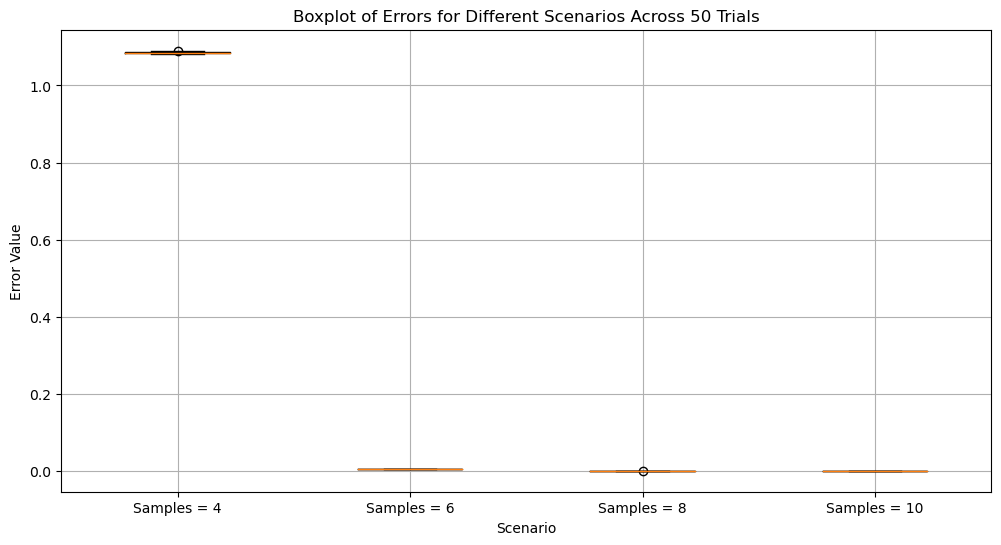

In [40]:
import matplotlib.pyplot as plt

# Assuming you have 4 scenarios and all_metrics is a dictionary of dictionaries
# Format: all_metrics[seed][scenario]

# Prepare data for boxplot
data_runs = [[] for _ in range(len(scenarios))]  # Adjust 'len(scenarios)' to the actual number of scenarios you have

for metrics in all_metrics.values():
    for i, n in enumerate(scenarios):
        data_runs[i].append(metrics[n])

# Create boxplots for these runs
plt.figure(figsize=(12, 6))
plt.boxplot(data_runs, labels=[f"Samples = {n}" for n in scenarios])
plt.title('Boxplot of Errors for Different Scenarios Across 50 Trials')
plt.xlabel('Scenario')
plt.ylabel('Error Value')
plt.grid(True)
plt.show()
